In [1]:
%matplotlib inline

from collections import OrderedDict
import glob
import re

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
palette = ["#003f5c", "#ef5675", "#ffa600"]
plt.rcParams["figure.facecolor"] = "white"

def annotate_plots(axs):
    axs[0].xaxis.set_visible(False)
    axs[0].set_ylabel("Cross-Validation", fontsize=20)
    axs[1].set_ylabel("Loss", fontsize=20)
    axs[1].set_xlabel("Iteration", fontsize=20)
    for ax in axs: 
        ax.yaxis.get_offset_text().set_fontsize(14)
        ax.tick_params("both", labelsize=14)

# Explaining Songbird parameters

One of the most frequent questions that arise when using Songbird is "*how do I pick good parameters?*". This is an incredibly point of consideration that we felt merited a short auxillary demonstration. Here, we will try to demystify what some of the important Songbird parameters are and how they can affect your model.

We will be using the data from the saliva microbiota study (from the reference frames paper).

## `epochs`

This is probably the simplest parameter to conceptualize. All `epochs` is doing is telling Songbird how many times to iterate over your dataset. The longer this goes, (ideally) the more your model will converge. If your graphs aren't plateauing yet (but are decreasing), you should increase your epochs while keeping the rest of the parameters the same.

* Formula: `C(brushing_event)`
* Learning Rate: `1e-3`
* Differential Prior: `10`

In [3]:
epochs_dict = sorted({
    re.search("epochs_(\d+)_stats.tsv", x).groups()[0]: pd.read_csv(x, sep="\t", index_col=0)
    for x in glob.glob("../results/vary_epochs/*_stats.tsv")
}.items(), key=lambda x: int(x[0]))
epochs_dict = OrderedDict(epochs_dict)

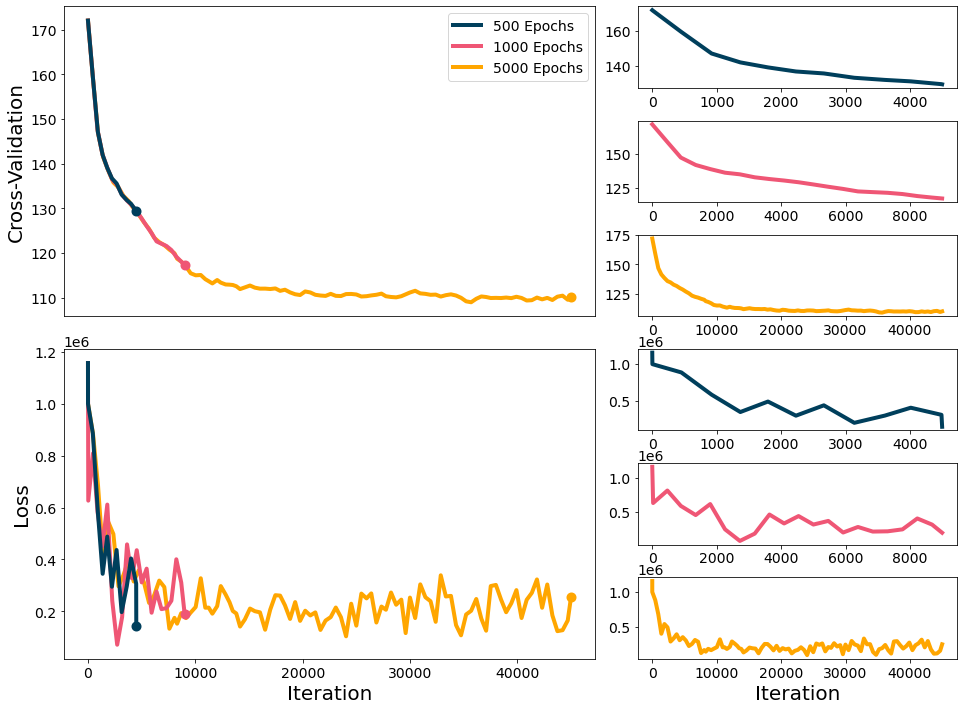

In [4]:
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(nrows=6, ncols=2, wspace=0.1, hspace=0.4, width_ratios=[1, 0.6])
big_cv = fig.add_subplot(gs[:3, 0])
big_loss = fig.add_subplot(gs[3:, 0], sharex=big_cv)

for i, (e, df) in enumerate(epochs_dict.items()):
    args = {"linewidth": 4, "zorder": 3-i, "color": palette[i]}
    big_cv.plot(df["iteration"], df["cross-validation"], label=f"{e} Epochs", **args)
    big_loss.plot(df["iteration"], df["loss"], **args)
    big_cv.scatter(df["iteration"].tail(1), df["cross-validation"].tail(1), **args)
    big_loss.scatter(df["iteration"].tail(1), df["loss"].tail(1), **args)
    
    small_cv = fig.add_subplot(gs[i, 1])
    small_loss = fig.add_subplot(gs[i+3, 1])
    
    small_cv.plot(df["iteration"], df["cross-validation"], **args)
    small_loss.plot(df["iteration"], df["loss"], **args)
    
    for ax in [small_cv, small_loss]: 
        ax.yaxis.get_offset_text().set_fontsize(14)
        ax.tick_params("both", labelsize=14)
    
big_cv.legend(fontsize=14)
small_loss.set_xlabel("Iteration", fontsize=20)
annotate_plots([big_cv, big_loss])

plt.show()

We see that if we only vary the number of `epochs`, the model proceeds longer without any significant difference in cross-validation or loss. The left side of the figure shows all the models overlaid while the right side shows the individual graphs (what you would see in a Songbird summary).

## `learning_rate`

The `learning_rate` of a Songbird model (or any model) is the step size (resolution) to take at each iteration. Songbird tries to iteratively learn which differential values are best for predicting the values in your table. The higher the `learning_rate`, the larger each step. This can result in faster convergence but risks overshooting the optimal values. A smaller `learning_rate` may be better for converging as close as possible to the optimal values, but setting this parameter too low will increase the time to converge.

* Formula: `C(brushing_event)`
* Epochs: `5000`
* Differential Prior: `10`

In [5]:
lr_dict = sorted({
    re.search("lr_(.*)_stats.tsv", x).groups()[0]: pd.read_csv(x, sep="\t", index_col=0)
    for x in glob.glob("../results/vary_learning_rate/*_stats.tsv")
}.items(), key=lambda x: float(x[0]))
lr_dict = OrderedDict(lr_dict)

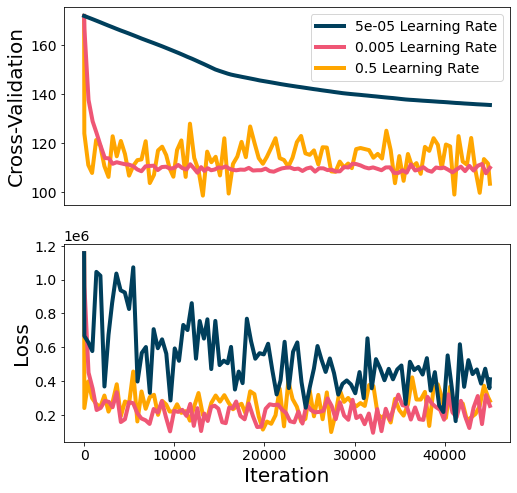

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

for i, (e, df) in enumerate(lr_dict.items()):
    args = {"linewidth": 4, "zorder": 3-i, "color": palette[i]}
    axs[0].plot(
        df["iteration"],
        df["cross-validation"],
        **args,
        label=f"{e} Learning Rate"
    )
    axs[1].plot(
        df["iteration"],
        df["loss"],
        **args,
    )
    
axs[0].legend(fontsize=14)
annotate_plots(axs)

plt.show()

We see that a learning rate of 0.5 is too high as the cross-validation graph continually bounces around the converged value. On the opposite side, a learning rate of 5e-5 is too low as it does not converge with our current number of epochs. It would likely take significantly more time for this model to reach convergence. A learning rate of 0.005 strikes a good balance between convergence and running time. You want to vary this parameter in conjunction with `epochs` to find a sweet spot where the model converges in a reasonable time frame.

## `differential_prior`

The `differential_prior` parameter controls the regularization of the differential values. This parameter has less to do with convergence and more to do with avoiding overfitting. Poor specification of `differential_prior` can result in the model essentially regurgitating the data rather than learning how to best predict data. This can best be seen in the cross-validation graph. If this graph starts increasing, that means the model is overfitting and isn't generalizing well. Smaller values of `differential_prior` will help to dampen the fitted differential values and decrease overfitting.

### Properly Fit

For the first model, we will investigate how `differential_prior` affects a model that is well specified and fit.

* Formula: `C(brushing_event)`
* Epochs: `5000`
* Learning Rate: `1e-3`

In [7]:
dp_good_dict = sorted({
    re.search("dp_(.*)_good_stats.tsv", x).groups()[0]: pd.read_csv(x, sep="\t", index_col=0)
    for x in glob.glob("../results/vary_differential_prior/*_good_stats.tsv")
}.items(), key=lambda x: float(x[0]))
dp_good_dict = OrderedDict(dp_good_dict)

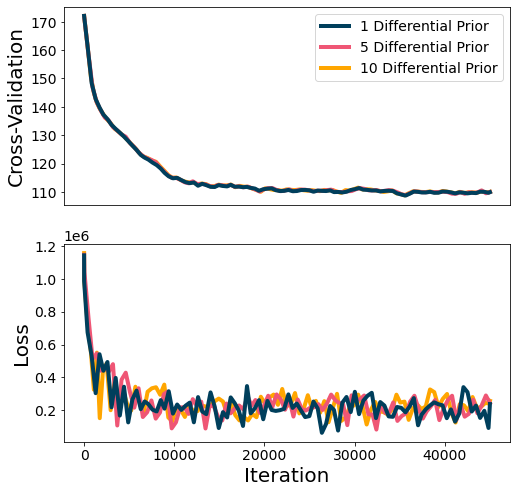

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

for i, (e, df) in enumerate(dp_good_dict.items()):
    args = {"linewidth": 4, "zorder": 3-i, "color": palette[i]}
    axs[0].plot(
        df["iteration"],
        df["cross-validation"],
        **args,
        label=f"{e} Differential Prior",
    )
    axs[1].plot(
        df["iteration"],
        df["loss"],
        **args,
    )
    
axs[0].legend(fontsize=14)
annotate_plots(axs)

plt.show()

We see that there is no difference among these three models. They all converge to the same place.

We can also compare the differential values of `brushing_event` to confirm that there is no appreciable difference in the rankings of these different models.

In [9]:
dp_good_diffs_dict = sorted({
    re.search("dp_(.*)_good_diff.tsv", x).groups()[0]: pd.read_csv(x, sep="\t", index_col=0)
    for x in glob.glob("../results/vary_differential_prior/*_good_diff.tsv")
}.items(), key=lambda x: float(x[0]))
dp_good_diffs_dict = OrderedDict(dp_good_diffs_dict)

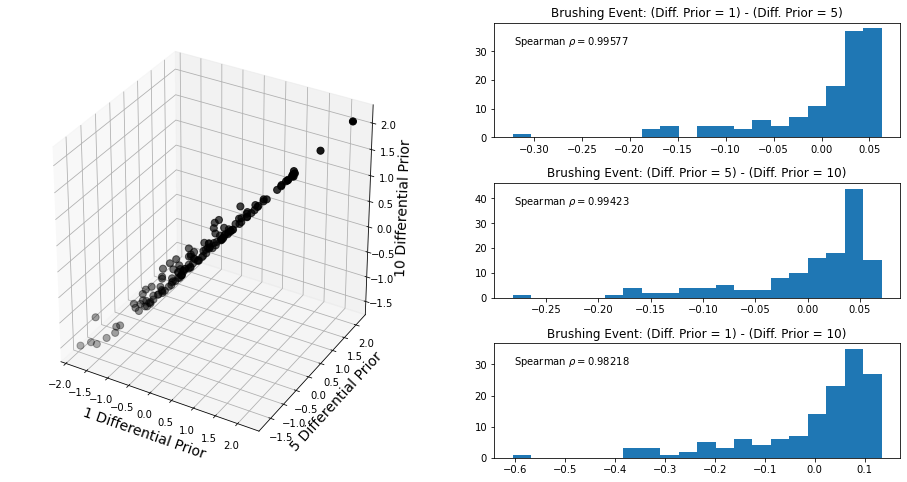

In [11]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(nrows=3, ncols=2, hspace=0.4)
ax = fig.add_subplot(gs[:3, 0], projection='3d')

args = {"c": "black", "s": 50}
_d = dict()
axis_labels = []
for val, (dp, df) in zip(["xs", "ys", "zs"], dp_good_diffs_dict.items()):
    args[val] = df["C(brushing_event)[T.before]"]
    _d[val] = dp
    axis_labels.append(f"{dp} Differential Prior")

ax.scatter(**args)
ax.set_xlabel(axis_labels[0], fontsize=14)
ax.set_ylabel(axis_labels[1], fontsize=14)
ax.set_zlabel(axis_labels[2], fontsize=14)

_x1 = args["xs"] - args["ys"]
_x2 = args["xs"] - args["zs"]
_x3 = args["ys"] - args["zs"]

ax4 = fig.add_subplot(gs[2, 1])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

import scipy.stats as ss

spearman_args = {"x": 0.05, "y": 0.9, "ha": "left", "va": "top"}
ax2.hist(_x1, bins=20)
ax2.set_title(f"Brushing Event: (Diff. Prior = {_d['xs']}) - (Diff. Prior = {_d['ys']})")
ax2.text(
    **spearman_args,
    transform=ax2.transAxes,
    s=f"Spearman $\\rho = ${round(ss.spearmanr(args['xs'], args['ys']).correlation, 5)}")
ax4.hist(_x2, bins=20)
ax4.set_title(f"Brushing Event: (Diff. Prior = {_d['xs']}) - (Diff. Prior = {_d['zs']})")
ax4.text(
    **spearman_args,
    transform=ax4.transAxes,
    s=f"Spearman $\\rho = ${round(ss.spearmanr(args['xs'], args['zs']).correlation, 5)}")
ax3.hist(_x3, bins=20)
ax3.set_title(f"Brushing Event: (Diff. Prior = {_d['ys']}) - (Diff. Prior = {_d['zs']})")
ax3.text(
    **spearman_args,
    transform=ax3.transAxes,
    s=f"Spearman $\\rho = ${round(ss.spearmanr(args['ys'], args['zs']).correlation, 5)}")


plt.show()

We also see that there is essentially no difference in the differentials fit by each of these models.

### Overfit

Now let's look at what happens with a model that doesn't fit so well off the bat.

* Formula: `HostSubject*brushing_event + final_volume_mL + final_tube_weight_g`
* Epochs: `5000`
* Learning Rate: `1e-3`

In [12]:
dp_bad_dict = sorted({
    re.search("dp_(.*)_bad_stats.tsv", x).groups()[0]: pd.read_csv(x, sep="\t", index_col=0)
    for x in glob.glob("../results/vary_differential_prior/*_bad_stats.tsv")
}.items(), key=lambda x: float(x[0]))
dp_bad_dict = OrderedDict(dp_bad_dict)

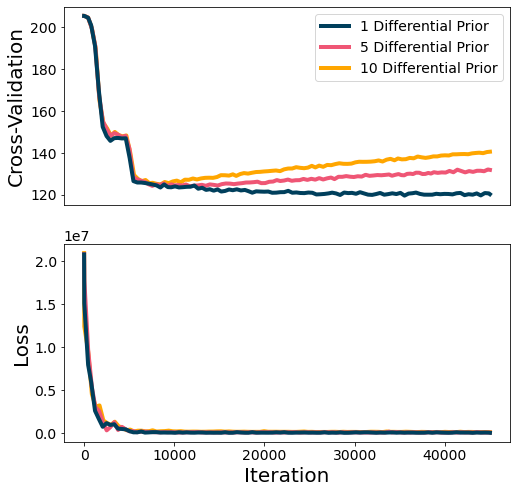

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

for i, (e, df) in enumerate(dp_bad_dict.items()):
    args = {"linewidth": 4, "zorder": 3-i, "color": palette[i]}
    axs[0].plot(
        df["iteration"],
        df["cross-validation"],
        **args,
        label=f"{e} Differential Prior",
    )
    axs[1].plot(
        df["iteration"],
        df["loss"],
        **args,
    )
    
axs[0].legend(fontsize=14)
annotate_plots(axs)

plt.show()

Notice how as differential prior increases, the tail end of the cross-validation graph increases in slope? By keeping this value lower, we can decrease this overfitting.

# Other considerations

There is a lot more to consider when using Songbird and unfortunately we don't have time to exhaustively cover all of them. We'll try to outline a couple things to keep in mind. As you try out different parameter sets and observe the results, you start to get a sense for how models can be improved.

## Proper formula specification

Picking a good formula is the core of any Songbird model. It's how you decide which factors are of interest and can drastically affect how a model performs (see the above difference between the good `learning_rate` model and the bad one). Be careful about including too many categorical levels in your model. If you have a metadata column with 6 levels then you are actually adding 5 variables to your formula.

In [14]:
np.random.seed(42)
test_series = pd.Series(np.random.choice(["A", "B", "C", "D", "E", "F"], size=50, p=[0.5, 0.2, 0.1, 0.1, 0.05, 0.05]))
test_series.name = "category"
test_series.value_counts()

A    28
B    11
D     3
F     3
C     3
E     2
Name: category, dtype: int64

In [15]:
from patsy import dmatrix
dmatrix("category", test_series.to_frame(), return_type="dataframe").head()

,Intercept,category[T.B],category[T.C],category[T.D],category[T.E],category[T.F]
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In this example, you want to make sure that you specify your training/testing samples properly. If you use random assignment, you may end up with a problematic class imbalance.

In these cases, think about if there are any ways to consolidate levels. Can you combine levels "C", "D", "E", and "F" in the above example? Of course, this is not always possible depending on your experimental design. Much of this will depend on your biological question - are you interested in microbial assoication with each level or are you primarily interested in level "A" & "B"? You can often re-encode your covariates or filter your samples to be more suitable for modeling.

There is debate about when it is appropriate to run differential abundance, but generally you should first see if samples separate via beta-diversity *then* run Songbird. If you see factors in the beta-diversiy plot that do not seem to be significantly different from other levels (via visual inspection, PERMANOVA, etc.), you can likely do some filtering or metadata shuffling.

## Filtering your feature table

Another important aspect of model fitting that often goes overlooked is making sure your filtering scheme is appropriate. Songbird filters your feature table by default but you should make sure that the resulting table makes sense for your analysis. For example, if you have thousands of samples you may want to be more stringent than requiring a feature to be in at least 10 samples. Conversely, if you have a small sample size make sure that you are not losing samples and/or features due to the default filtering scheme.

Personally, I like to filter upstream of Songbird and pass in parameters `min_sample_count=0` and `min_feature_count=0` so I can know ahead of time how many samples/features are being incorporated into the model.

# Grid search for Songbird parameters

One option for fitting parameters in Songbird is to perform a parameter [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search). This procedure evaluates several different sets of parameters (often in parallel) to determine which parameter sets result in better models via some evaluation criteria. I have a [repository](https://github.com/gibsramen/songbird_parameter_pipeline) that does a pseudo grid search that can be run on barnacle via Snakemake. However, do note that this repository is no longer actively updated.

It is not super-complicated to implement this yourself, but be aware that just maximizing $Q^2$ as a target is not sufficient for finding a good model. You must inspect the cross-validation and loss graphs as well to make sure they are appropriate for downstream analysis on fitted differentials.

Rough pseudocode for such a grid search procedure is below:

```
formula <- "body_site"
for param1 in param1_options:
    for param2 in param2_options:
        regression_model <- multinomial(formula, param1, param2, ...)
        null_model <- multinomial("1", param1, param2, ...)
        save regression and null results
tabulate stats (CV, loss, Q^2, etc.) of each model
```

An example of a grid search procedure for Songbird can be seen [here](https://github.com/ETaSky/seeding-study/blob/master/code/2.1.4-songbird-analysis-TP-model-with-training.ipynb).

# Final thoughts

We hope this was a helpful demonstration of how to improve your Songbird models. At the end of the day, Songbird is just a way to point towards features that are relatively associated with metadata. The differentials themselves should guide downstream analyses whether via Qurro or some other method. A $Q^2$ value of 0.26 vs 0.25 is not likely to significantly affect your further findings.